# Reconhecimento de marcas em imagens com Kaggle

Dataset Kaggle disponível [aqui](https://www.kaggle.com/momotabanerjee/brand-logo-recognition-dataset) e foi salvo na pasta `data`.

## Configurando o ambiente

In [1]:
!pip install --upgrade azure-cognitiveservices-vision-computervision
!pip install pillow

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [86]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient 
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes, Details
from types import SimpleNamespace
import json
from os import walk
import os
from PIL import Image
import pandas as pd
from io import BytesIO
import matplotlib
import matplotlib.pyplot as plt


### Configurando a conexão com o Azure Computer Vision

In [5]:
appsettings = {}

with open('appsettings.json') as f:
    appsettings = json.loads(f.read(), object_hook=lambda d: SimpleNamespace(**d))

credentials = CognitiveServicesCredentials(appsettings.azure_key)
client = ComputerVisionClient(appsettings.azure_endpoint, credentials)
print(client.api_version)

3.2


## Lendo os dados do diretório

In [8]:
base_path = 'data/kaggle_logos_dataset'
filenames = next(walk(base_path), (None, None, []))[2]

## Funções azure

In [89]:
def get_brands(analise):
    brands = []
    for brand in analise.brands:
        brands.append({
            'name': brand.name,
            'confidence': brand.confidence,
            'rectangle': {
                'x': brand.rectangle.x,
                'y': brand.rectangle.y,
                'w': brand.rectangle.w,
                'h': brand.rectangle.h
            }
        })        
    return brands

In [90]:
def get_tags(analysis):
    tags = []
    for tag in analysis.tags:
        tags.append({
            'name': tag.name,
            'confidence': tag.confidence
        })
    return tags

In [91]:
def get_caption(analysis):
    captions = []    
    for c in analysis.description.captions:
        captions.append({
            'text': c.text,
            'confidence': c.confidence
        })
    return captions

In [92]:
def analyze_image(image):
    analysis = client.analyze_image_in_stream(image, visual_features=[VisualFeatureTypes.brands, VisualFeatureTypes.tags, VisualFeatureTypes.description, VisualFeatureTypes.objects])
    brands = get_brands(analysis)
    tags = get_tags(analysis)
    captions = get_caption(analysis)    
    return {
        'brands': brands,
        'tags': tags,
        'captions': captions
    }

In [93]:
def get_image_stream(filename):
    img = base_path + '/'+ filename
    image = Image.open(img)

    png_bytes_io = BytesIO()
    image.save(png_bytes_io, format='JPEG')
    png_bytes_io.seek(0)
    return png_bytes_io

In [94]:
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [95]:
def save_as_json(analysis_result, filename):
    directory = 'data/json/'
    create_directory(directory)
    filename = directory + filename.split('.')[0] + '.json'
    with open(filename, 'w') as f:
        json.dump(analysis_result, f)

In [100]:
def analyze_all_images(filenames):
    predictions = []
    l = len(filenames)
    i = 0
    for filename in filenames:
        i += 1
        print(f'Analisando imagem ({i}/{l}): {filename}')
        image_stream = get_image_stream(filename)
        analysis_result = analyze_image(image_stream)
        save_as_json(analysis_result, filename)
        predictions.append(create_prediction_item(analysis_result, filename))
        draw_rectangle(filename, analysis_result['brands'][0]['rectangle'])
    return pd.DataFrame(predictions)

In [97]:
def create_prediction_item(analysis_result, filename):
    brand = ''
    if(len(analysis_result['brands']) > 0):
        brand = analysis_result['brands'][0]['name']

    caption = ''
    if(len(analysis_result['captions']) > 0):
        caption = analysis_result['captions'][0]['text']

    return {
            'filename': filename,
            'brand': brand,
            'caption': caption
        }

In [102]:
def draw_rectangle(filaname, rectangle):
    fullName = base_path + '/'+ filaname
    img = matplotlib.image.imread(fullName)
    figure, ax = plt.subplots(1)
    rect = matplotlib.patches.Rectangle((rectangle['x'], rectangle['y']), rectangle['w'], rectangle['h'], fill=False, edgecolor='red', linewidth=2)
    ax.imshow(img)
    ax.add_patch(rect)
    directory = 'data/marked_images/'
    create_directory(directory)
    plt.savefig(directory + filaname)

Analisando imagem (1/10): 106523337.jpg
Analisando imagem (2/10): 1075391489.jpg
Analisando imagem (3/10): 108232382.jpg
Analisando imagem (4/10): 108232417.jpg
Analisando imagem (5/10): 109950015.jpg
Analisando imagem (6/10): 110022360.jpg
Analisando imagem (7/10): 1107796028.jpg
Analisando imagem (8/10): 1111800334.jpg
Analisando imagem (9/10): 111389662.jpg
Analisando imagem (10/10): 115519078.jpg


,filename,brand,caption
0,106523337.jpg,Ford,a close up of a car's logo
1,1075391489.jpg,NBC,a close up of a logo
2,108232382.jpg,Citroen,a black and white photo of a letter on a black...
3,108232417.jpg,Mini,a close up of a watch
4,109950015.jpg,Mini,a close up of a car's license plate


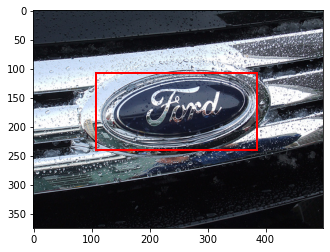

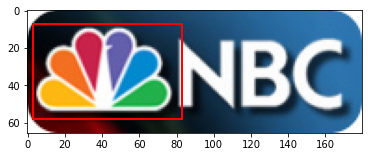

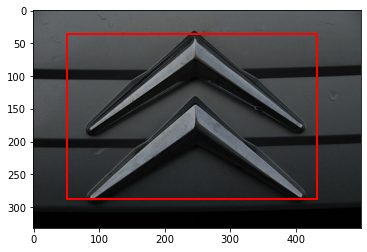

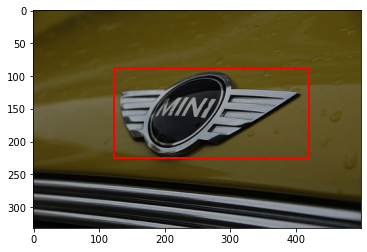

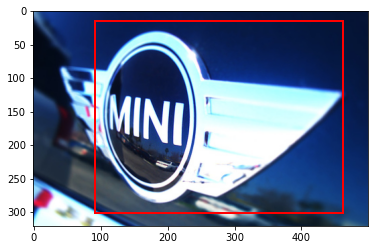

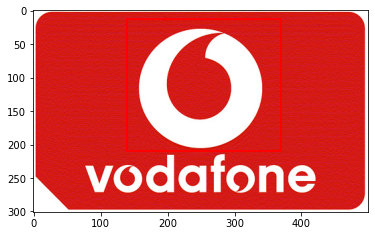

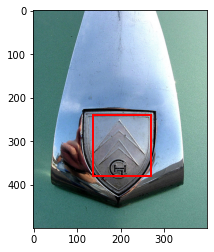

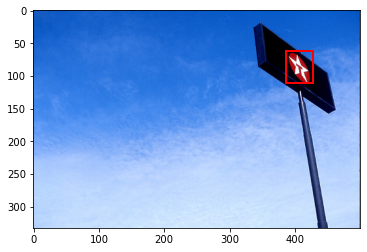

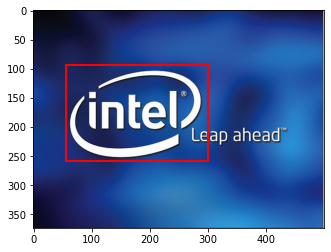

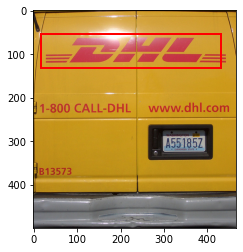

In [103]:
predictions = analyze_all_images(filenames[:10])
predictions.head()